In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import glob
import ipyparallel as ipp
import matplotlib.pyplot as plt
import os
import pandas as pd
import PTA

from IPython.display import display

pd.set_option('display.max_columns', None)

ipyclient = ipp.Client(cluster_id="PTA")
print(len(ipyclient))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
45


In [33]:
!rm analysis/simulations/Gecko-3pops-recent-SIMOUT.csv

In [3]:
model = PTA.DemographicModel("Gecko-3pops-recent")
model.set_param("project_dir", "analysis/simulations")
model.set_param("npops", 3)
model.set_param("nsamps", 8)
# Contemporary Ne from stairway plots
model.set_param("N_e", "2e5-5.5e5")
model.set_param("tau", "1e4-1e5")
model.set_param("epsilon", "0.1")
model.set_param("zeta", 0)
model.set_param("length", "300")
#computationally impractical to simulate 2e4 loci for 20 pops, but this is how you'd do it.
#model.set_param("num_replicates", [nloci_dict[x] for x in expanding_pops])
model.set_param("num_replicates", 1000)
model.set_param("recoms_per_gen", 0)
# Mut rate from manuscript, following Harrington et al 2018
model.set_param("muts_per_gen", 2.2e-9)
print(model.get_params())

model._hackersonly["sorted_sfs"] = True
model._hackersonly["proportional_msfs"] = True
model._hackersonly["tau_buffer"] = 100000
model._hackersonly["Ne_loguniform"] = False
model.simulate(nsims=50000, quiet=False, verbose=False, ipyclient=ipyclient)

------- PTA params - DemographicModel - (v.0.0.11) -----------------------------
Gecko-3pops-recent   ## [0] [simulation_name]: The name of this simulation scenario
/home/isaac/proj/Islands2030/PTA-GalapagosGeckos/analysis/simulations ## [1] [project_dir]: Where to save files
3                    ## [2] [npops]: Number of populations undergoing co-demographic processes
8                    ## [3] [nsamps]: Numbers of samples for each populations
200000-550000        ## [4] [N_e]: Effective population size of the contemporary population
10000-100000         ## [5] [tau]: Time of demographic change
0.1                  ## [6] [epsilon]: Magnitude of demographic change
0.0                  ## [7] [zeta]: Proportion of coexpanding taxa. Default will sample U~(0, 1)
300                  ## [8] [length]: Length in bp of each independent genomic region to simulate
1000,1000,1000       ## [9] [num_replicates]: Number of genomic regions to simulate
1                    ## [10] [generation_time]

In [4]:
# The 'reference table'
sorted_sim_df = pd.read_csv("analysis/simulations/Gecko-3pops-recent-SIMOUT.csv", sep=" ")

# Drop zeta_e == 0 (meaningless)
sorted_sim_df = sorted_sim_df[sorted_sim_df.zeta_e > 0]
print(len(sorted_sim_df))
# This is a input
synthetic_community = pd.DataFrame(sorted_sim_df.loc[0]).T.drop(PTA.inference.default_targets, axis=1)

## RF parameters from a cv_search process which took like a day, don't want to redo it.
rf_params = {'bootstrap': True,
 'ccp_alpha': 0.0,
 'max_depth': 70,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 4,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1400,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}
rf_sorted_cl = PTA.inference.Classifier(empirical_df=synthetic_community,
                                       sims=sorted_sim_df,
                                       algorithm="rf")
# Set GB model params
rf_sorted_cl.set_params(rf_params)
# Set the target for classification
rf_sorted_cl.set_targets(["zeta_e"])
# Run quickly to set up the model
rf_sorted_cl.predict(select_features=False, param_search=False, quick=True, verbose=True)
# Do the cross validation prediction
cv_preds = rf_sorted_cl.cross_val_predict(cv=3,
                    quick=True,
                    verbose=True)

150000
Predict() started: 2023-12-14 14:51:53.297413
Predict() finished: 2023-12-14 14:52:13.878205


/home/isaac/miniconda3/envs/PTA/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1050: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/isaac/miniconda3/envs/PTA/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/isaac/miniconda3/envs/PTA/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1050: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/isaac

              precision    recall  f1-score   support

           1       0.54      0.58      0.56     49859
           2       0.44      0.25      0.32     50080
           3       0.55      0.74      0.63     50061

    accuracy                           0.53    150000
   macro avg       0.51      0.53      0.50    150000
weighted avg       0.51      0.53      0.50    150000



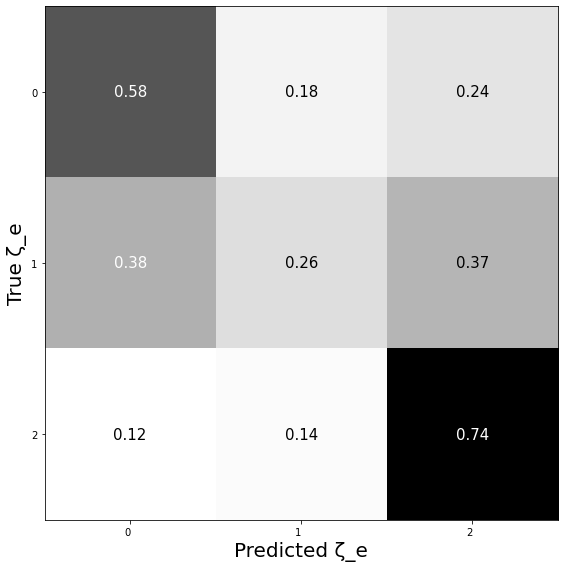

In [45]:
ax = rf_sorted_cl.plot_confusion_matrix(normalize=True)

,pop0-[[7_1]],pop0-[[6_2]],pop0-[[5_3]],pop0-[[4_4]],pop1-[[7_1]],pop1-[[6_2]],pop1-[[5_3]],pop1-[[4_4]],pop2-[[7_1]],pop2-[[6_2]],pop2-[[5_3]],pop2-[[4_4]]
0,0.596941,0.212706,0.158181,0.069528,0.593813,0.203757,0.137826,0.064843,0.581962,0.19033,0.128638,0.061477


Predict() started: 2023-12-14 14:56:17.157419


,1,2,3
zeta_e,0.016109,0.061956,0.921935


CPU times: user 373 ms, sys: 83.4 ms, total: 457 ms
Wall time: 409 ms


<BarContainer object of 3 artists>

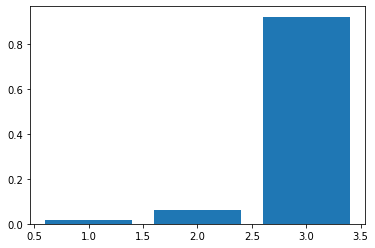

In [6]:
%%time
# Load msfs and reshape it into a format the ML stuff expects
sorted_expanding_msfs = pd.read_csv("/home/isaac/proj/Islands2030/PTA-GalapagosGeckos/analysis/msfs/recent-proj8-sort-props.msfs", index_col=0)
sorted_expanding_msfs = pd.DataFrame(sorted_expanding_msfs.to_numpy().ravel(order="F"), index=synthetic_community.columns).T
display(sorted_expanding_msfs)

rf_sorted_cl.set_data(sorted_expanding_msfs)
rf_class_est = rf_sorted_cl.predict(select_features=False,\
                                    param_search=False,\
                                    quick=True,\
                                    verbose=True)
#axs = gb_sorted_cl.plot_feature_importance()
display(rf_class_est[1])
plt.bar(range(1, 4), rf_class_est[1].values[0])

Removed invariant targets. Retained: ['t_s', 'taus_mean']
Predict() started: 2023-12-14 14:57:49.435812
Predict() finished: 2023-12-14 14:57:58.864652


/home/isaac/miniconda3/envs/PTA/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/isaac/miniconda3/envs/PTA/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/isaac/miniconda3/envs/PTA/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this param

                    MAE        RMSE    vscore       R2
t_s        28649.464981  156.593998  0.813241  0.81324
taus_mean  28649.464981  156.593998  0.813241  0.81324
taus_std       0.000000    0.000000  1.000000  1.00000
CPU times: user 7min 59s, sys: 23.1 s, total: 8min 22s
Wall time: 54.6 s


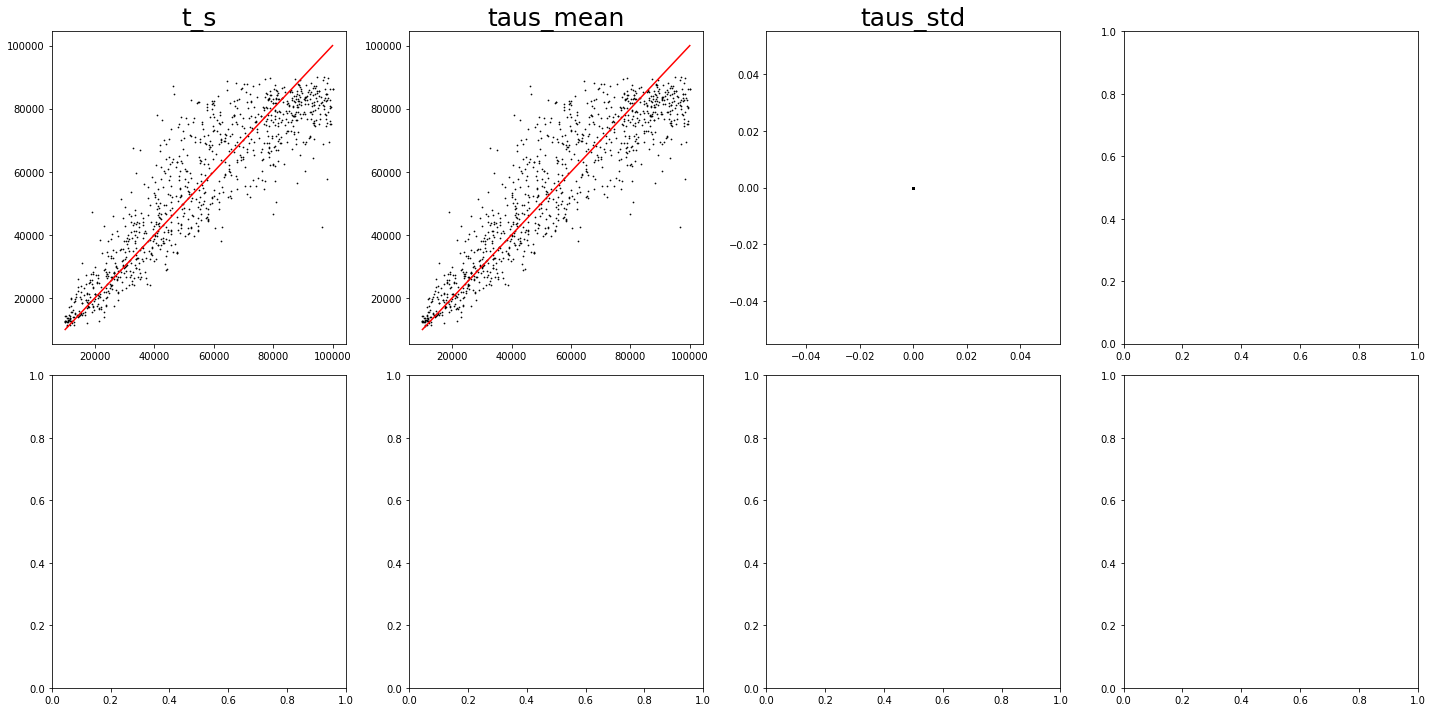

In [7]:
%%time
inferred_zeta_e = 3

pruned_sorted_df = sorted_sim_df[sorted_sim_df["zeta_e"] == inferred_zeta_e]

rf_rgr = PTA.inference.Regressor(empirical_df=synthetic_community,\
                                sims=pruned_sorted_df,\
                                algorithm="rf",\
                                verbose=True)
rf_rgr.set_params(rf_params)
rf_rgr.set_targets(["t_s", "taus_mean", "taus_std"])
rf_rgr.predict(select_features=False,\
            param_search=False,\
            quick=False,\
            verbose=True)
rg_rgr_preds = rf_rgr.cross_val_predict(verbose=True)
ax = rf_rgr.plot_cv_predictions(figsize=(20,10), figdims=(2,4))

In [8]:
rf_param_est = rf_rgr.predict(sorted_expanding_msfs)
rf_param_est

,t_s,taus_mean,taus_std
estimate,37659.036089,37659.036089,0.0


In [9]:
import numpy as np
def pred_ints(model, X, percentile=95):
    preds = []
    err_down = []
    err_up = []
    for pred in model.best_model.estimators_:
        preds.append(pred.predict(X))
        err_down = np.percentile(preds, (100 - percentile) / 2. , axis=0)[0]
        err_up = np.percentile(preds, 100 - (100 - percentile) / 2., axis=0)[0]
    return err_down, err_up

err_down, err_up = pred_ints(rf_rgr, sorted_expanding_msfs)
pred_intervals = pd.DataFrame(np.array([err_down, rf_param_est.values[0], err_up]), columns=rf_param_est.columns)
pred_intervals

,t_s,taus_mean,taus_std
0,18999.583333,18999.583333,0.0
1,37659.036089,37659.036089,0.0
2,38751.875000,38751.875000,0.0


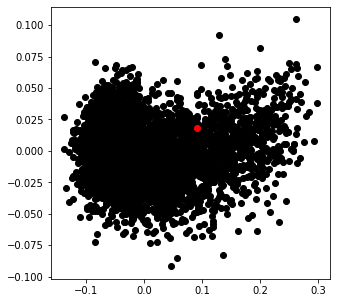

In [47]:
from sklearn.decomposition import PCA

estimated_zeta = 3

dat = sorted_sim_df[sorted_sim_df["zeta_e"] == estimated_zeta].iloc[:5000, 23:]
dat = pd.concat([sorted_expanding_msfs, dat])

pca = PCA(n_components=2)
pcs = pca.fit_transform(dat)

fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(pcs[:, 0], pcs[:, 1], c='black')
## Plot the observed ss in red
ax.scatter(pcs[:, 0][0], pcs[:, 1][0], c='r')

In [48]:
dat = sorted_sim_df[sorted_sim_df["zeta_e"] == 3].iloc[:1000, 23:]
dat

,pop0-[[7_1]],pop0-[[6_2]],pop0-[[5_3]],pop0-[[4_4]],pop1-[[7_1]],pop1-[[6_2]],pop1-[[5_3]],pop1-[[4_4]],pop2-[[7_1]],pop2-[[6_2]],pop2-[[5_3]],pop2-[[4_4]]
1,0.689,0.208,0.123,0.053,0.672,0.168,0.110,0.046,0.633,0.165,0.097,0.035
5,0.687,0.180,0.108,0.054,0.671,0.168,0.108,0.054,0.666,0.159,0.100,0.046
6,0.615,0.225,0.192,0.079,0.560,0.192,0.160,0.069,0.537,0.179,0.138,0.055
14,0.669,0.204,0.108,0.062,0.647,0.191,0.101,0.051,0.646,0.184,0.098,0.039
25,0.680,0.177,0.136,0.053,0.658,0.169,0.112,0.050,0.651,0.162,0.109,0.044
...,...,...,...,...,...,...,...,...,...,...,...,...
2928,0.632,0.195,0.132,0.064,0.625,0.180,0.131,0.059,0.617,0.179,0.129,0.057
2930,0.687,0.205,0.124,0.065,0.677,0.168,0.097,0.060,0.642,0.156,0.083,0.034
2934,0.691,0.207,0.102,0.062,0.648,0.199,0.102,0.047,0.647,0.161,0.092,0.043
2939,0.677,0.195,0.123,0.052,0.674,0.167,0.118,0.047,0.651,0.153,0.113,0.031


## Trash